In [2]:
#!/usr/bin/env python
"""
Example usage of camera class
@author: Dorian Tsai
"""

import numpy as np
import machinevisiontoolbox as mvt
import cv2 as cv 
import matplotlib.pyplot as plt

%matplotlib inline

c = mvt.Camera()

# test basic properties/setters/getters
print(c.name)
c.name = 'machine vision toolbox'
print(c.name)

print(c.K)

print('\n')
c.printCameraAttributes()
print('\n')

print(c.t)
c.t = np.r_[1, 2, 3]
print(c.t)
print(c.T)

print(c.rpy)
c.rpy = np.r_[0.1, 0.2, 0.3]
print(c.rpy)
print(c.T.A)


principal point not specified,                    setting it to centre of image plane
mvtcamera
machine vision toolbox
[[800.   0. 250.]
 [  0. 800. 250.]
 [  0.   0.   1.]]


_name : 	 machine vision toolbox
_camtype : 	 perspective
_fu : 	 [0.008]
_fv : 	 [0.008]
_rhou : 	 [1.e-05]
_rhov : 	 [1.e-05]
_nu : 	 500.0
_nv : 	 500.0
_u0 : 	 250.0
_v0 : 	 250.0
_T : 	 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
_image : 	 None
_fig : 	 None
_ax : 	 None


[0. 0. 0.]


AttributeError: can't set attribute

creating new figure and axes for camera
creating new figure and axes for camera


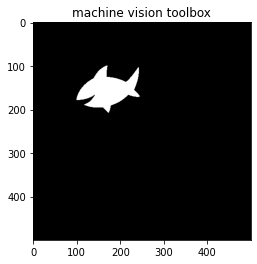

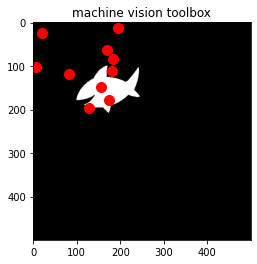

In [10]:

"""
projecting points onto an image
TODO verify
"""

npts = 10
p = np.random.randint(0, 200, (2, npts))

imfile = '../images/shark1.png'
im = mvt.iread(imfile)

c.image = im
c.plotcreate()
c.plot(p) 


principal point not specified,                    setting it to centre of image plane
   1           0           0           0.1          
   0           1           0           0.2          
   0           0           1           0.3          
   0           0           0           1            

   1           0           0           0.1          
   0           1           0           0.2          
   0           0           1           0.3          
   0           0           0           1            

[[ -75.92592593  121.60493827  319.13580247  516.66666667  -75.92592593
   121.60493827  319.13580247  516.66666667  -75.92592593  121.60493827
   319.13580247  516.66666667  -75.92592593  121.60493827  319.13580247
   516.66666667  -75.92592593  121.60493827  319.13580247  516.66666667]
 [-105.55555556 -105.55555556 -105.55555556 -105.55555556   42.59259259
    42.59259259   42.59259259   42.59259259  190.74074074  190.74074074
   190.74074074  190.74074074  338.88888889  338.888888

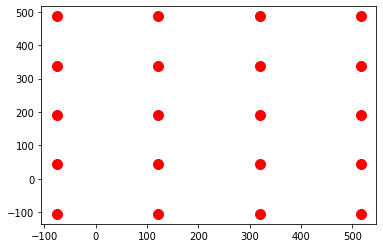

[[-164.81481481   32.71604938  230.24691358  427.77777778 -164.81481481
    32.71604938  230.24691358  427.77777778 -164.81481481   32.71604938
   230.24691358  427.77777778 -164.81481481   32.71604938  230.24691358
   427.77777778 -164.81481481   32.71604938  230.24691358  427.77777778]
 [-105.55555556 -105.55555556 -105.55555556 -105.55555556   42.59259259
    42.59259259   42.59259259   42.59259259  190.74074074  190.74074074
   190.74074074  190.74074074  338.88888889  338.88888889  338.88888889
   338.88888889  487.03703704  487.03703704  487.03703704  487.03703704]]
creating new figure and axes for camera


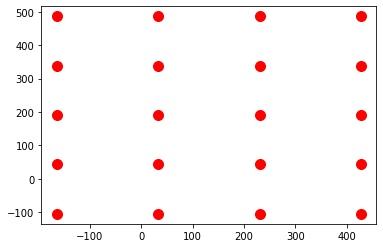

Fund mat =  [[ 2.74968340e-12 -2.45434250e-22  1.12500002e-02]
 [-2.45434259e-22  1.44543115e-46 -6.36226713e-20]
 [-1.12500008e-02 -8.54390485e-20  1.00000000e+00]]


In [3]:
"""
Fundamental matrix
"""

import spatialmath.base as tr
from spatialmath import SE3

c = mvt.Camera()
c.T = SE3([0.1, 0.2, 0.3])
# c.rpy = np.r_[0.1, 0.2, 0.3]
print(c.T)
# fig, ax = c.plot_camera(frustum=True)
# plt.show()

# fundamental matrix
# create +8 world points (20 in this case)
nx, ny = (4, 5)
depth = 3
x = np.linspace(-1, 1, nx)
y = np.linspace(-1, 1, ny)
X, Y = np.meshgrid(x, y)
Z = depth * np.ones(X.shape)
P = np.dstack((X, Y, Z))
PC = np.ravel(P, order='C')
PW = np.reshape(PC, (3, nx * ny), order='F')

# create projections from pose 1:
print(c.T)
p1 = c.project(PW)  # p1 wrt c's T
print(p1)
c.plot(p1)


# define pose 2:
T2 = SE3([0.4, 0.2, 0.3])  # just pure x-translation
p2 = c.project(PW, T2)
print(p2)
c.plot(p2)


# convert p1, p2 into lists of points?
p1 = np.float32(np.transpose(p1))
p2 = np.float32(np.transpose(p2))
F = c.FfromPoints(np.float32(p1), p2,
                    method=cv.FM_8POINT,
                    ransacReprojThresh=3,
                    confidence=0.99,
                    maxiters=10)


creating new figure and axes for camera


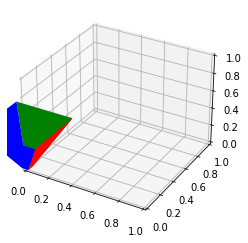

In [12]:

# plot_camera?
fig, ax = c.plot_camera(frustum=True)
plt.show()
